In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from scipy.spatial.distance import cdist

load C:\Users\naufa\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\zlib1.dll...
load C:\Users\naufa\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\abseil_dll.dll...
load C:\Users\naufa\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\utf8_validity.dll...
load C:\Users\naufa\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\re2.dll...
load C:\Users\naufa\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\libprotobuf.dll...
load C:\Users\naufa\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\highs.dll...
load C:\Users\naufa\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\ortools.dll...


In [2]:
url_boundary = "https://raw.githubusercontent.com/naufalaschafitz/TugasAkhir/refs/heads/main/coordinates_with_region.csv"
url_centroids = "https://raw.githubusercontent.com/naufalaschafitz/TugasAkhir/refs/heads/main/Centroids.csv"
df_boundary = pd.read_csv(url_boundary)
df_centroids = pd.read_csv(url_centroids)

outer_points = df_boundary[df_boundary["Region"] == "outer"][["X", "Y"]].values
inner_1_points = df_boundary[df_boundary["Region"] == "inner_1"][["X", "Y"]].values
inner_2_points = df_boundary[df_boundary["Region"] == "inner_2"][["X", "Y"]].values
inner_3_points = df_boundary[df_boundary["Region"] == "inner_3"][["X", "Y"]].values

outer_points_closed = np.vstack([outer_points, outer_points[0]])
inner_1_points_closed = np.vstack([inner_1_points, inner_1_points[0]])
inner_2_points_closed = np.vstack([inner_2_points, inner_2_points[0]])
inner_3_points_closed = np.vstack([inner_3_points, inner_3_points[0]])

centroids = df_centroids[["X", "Y"]].values
main_labels = df_centroids["MainCluster"].values
sub_labels = df_centroids["SubCluster"].values

# Peta warna
unique_clusters = sorted(set(main_labels))
cmap = plt.get_cmap("tab10", len(unique_clusters))
cluster_color_map = {c: cmap(i) for i, c in enumerate(unique_clusters)}


In [3]:
# Extract centroid coordinates and append depot
all_centroids = df_centroids[["X", "Y"]].values
coords_with_depot = np.vstack([[0, 0], all_centroids])

In [6]:
distance_matrix = cdist(coords_with_depot, coords_with_depot)

def fitness(tour, distance_matrix):
    return sum(distance_matrix[tour[i], tour[i+1]] for i in range(len(tour)-1)) + distance_matrix[tour[-1], tour[0]]

def generate_greedy_initial_route(distance_matrix):
    n = len(distance_matrix)
    unvisited = set(range(1, n))  # node 0 = depot, jadi mulai dari 1
    route = [0]  # mulai dari depot

    current = 0
    while unvisited:
        next_node = min(unvisited, key=lambda x: distance_matrix[current][x])
        route.append(next_node)
        unvisited.remove(next_node)
        current = next_node

    return route

def two_opt(route, distance_matrix, max_iter=1000):
    best = route
    improved = True
    while improved and max_iter > 0:
        improved = False
        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route) - 1):
                if j - i == 1:
                    continue  # Skip adjacent nodes
                new_route = best[:i] + best[i:j][::-1] + best[j:]
                if fitness(new_route, distance_matrix) < fitness(best, distance_matrix):
                    best = new_route
                    improved = True
        max_iter -= 1
    return best

def get_neighbor(route):
    new_route = route[:]
    i, j = sorted(np.random.choice(range(1, len(route)), size=2, replace=False))  # hindari depot (index 0)
    move_type = np.random.choice(["reverse", "swap", "insert"])

    if move_type == "reverse":
        new_route[i:j+1] = reversed(new_route[i:j+1])

    elif move_type == "swap":
        new_route[i], new_route[j] = new_route[j], new_route[i]

    elif move_type == "insert":
        node = new_route.pop(i)
        new_route.insert(j, node)

    return new_route


def simulated_annealing_with_periodic_2opt(
    distance_matrix,
    initial_route,
    initial_temp=100,
    cooling_rate=0.995,
    stopping_temp=1e-4,
    max_iter=1000,
    interval_log=50,
    n_iter_2opt=10,
    local_max_iter=30
):
    current_route = initial_route[:]
    current_cost = fitness(current_route, distance_matrix)
    best_route = current_route[:]
    best_cost = current_cost
    temperature = initial_temp
    cost_log = []

    iteration = 0
    while temperature > stopping_temp and iteration < max_iter:
        # Tetangga: reverse segment (2-opt-like ringan)
        neighbor_route = get_neighbor(current_route)

        # Setiap n iterasi → refine dengan 2-Opt
        if iteration % n_iter_2opt == 0:
            neighbor_route = two_opt(neighbor_route, distance_matrix, max_iter=local_max_iter)

        neighbor_cost = fitness(neighbor_route, distance_matrix)

        # Acceptance
        if neighbor_cost < current_cost or np.random.rand() < np.exp((current_cost - neighbor_cost) / temperature):
            current_route = neighbor_route
            current_cost = neighbor_cost
            if current_cost < best_cost:
                best_route = current_route[:]
                best_cost = current_cost

        cost_log.append(current_cost)
    

        if iteration % interval_log == 0:
            print(f"Iterasi {iteration:4d} | Cost: {current_cost:.2f} | Best: {best_cost:.2f} | Suhu: {temperature:.2f}")

        # Cooling
        temperature *= cooling_rate
        iteration += 1

    print(f"Final Iterasi {iteration} | Best Cost: {best_cost:.2f}")
    return best_route, best_cost, cost_log



Iterasi    0 | Cost: 1846.12 | Best: 1846.12 | Suhu: 100.00
Iterasi   50 | Cost: 1853.28 | Best: 1844.45 | Suhu: 77.83
Iterasi  100 | Cost: 1948.64 | Best: 1844.45 | Suhu: 60.58
Iterasi  150 | Cost: 1885.47 | Best: 1844.45 | Suhu: 47.15
Iterasi  200 | Cost: 1882.24 | Best: 1844.45 | Suhu: 36.70
Iterasi  250 | Cost: 1932.03 | Best: 1844.45 | Suhu: 28.56
Iterasi  300 | Cost: 1763.30 | Best: 1763.30 | Suhu: 22.23
Iterasi  350 | Cost: 1760.15 | Best: 1757.12 | Suhu: 17.30
Iterasi  400 | Cost: 1751.85 | Best: 1746.29 | Suhu: 13.47
Iterasi  450 | Cost: 1751.85 | Best: 1746.29 | Suhu: 10.48
Iterasi  500 | Cost: 1751.17 | Best: 1746.29 | Suhu: 8.16
Iterasi  550 | Cost: 1763.10 | Best: 1746.29 | Suhu: 6.35
Iterasi  600 | Cost: 1754.15 | Best: 1746.29 | Suhu: 4.94
Iterasi  650 | Cost: 1740.37 | Best: 1740.37 | Suhu: 3.85
Iterasi  700 | Cost: 1734.94 | Best: 1734.94 | Suhu: 2.99
Iterasi  750 | Cost: 1734.94 | Best: 1734.94 | Suhu: 2.33
Iterasi  800 | Cost: 1734.94 | Best: 1734.94 | Suhu: 1.81
Ite

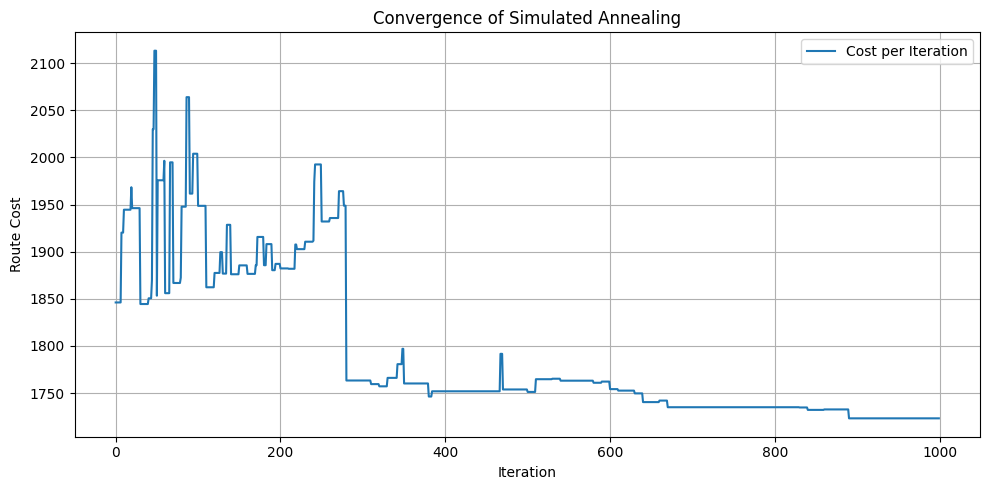

In [14]:
initial_route = generate_greedy_initial_route(distance_matrix)
hybrid_route, hybrid_cost, cost_log = simulated_annealing_with_periodic_2opt(distance_matrix, initial_route)

# Visualisasi Konvergensi (langsung)
plt.figure(figsize=(10, 5))
plt.plot(cost_log, label='Cost per Iteration')
plt.title('Convergence of Simulated Annealing')
plt.xlabel('Iteration')
plt.ylabel('Route Cost')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

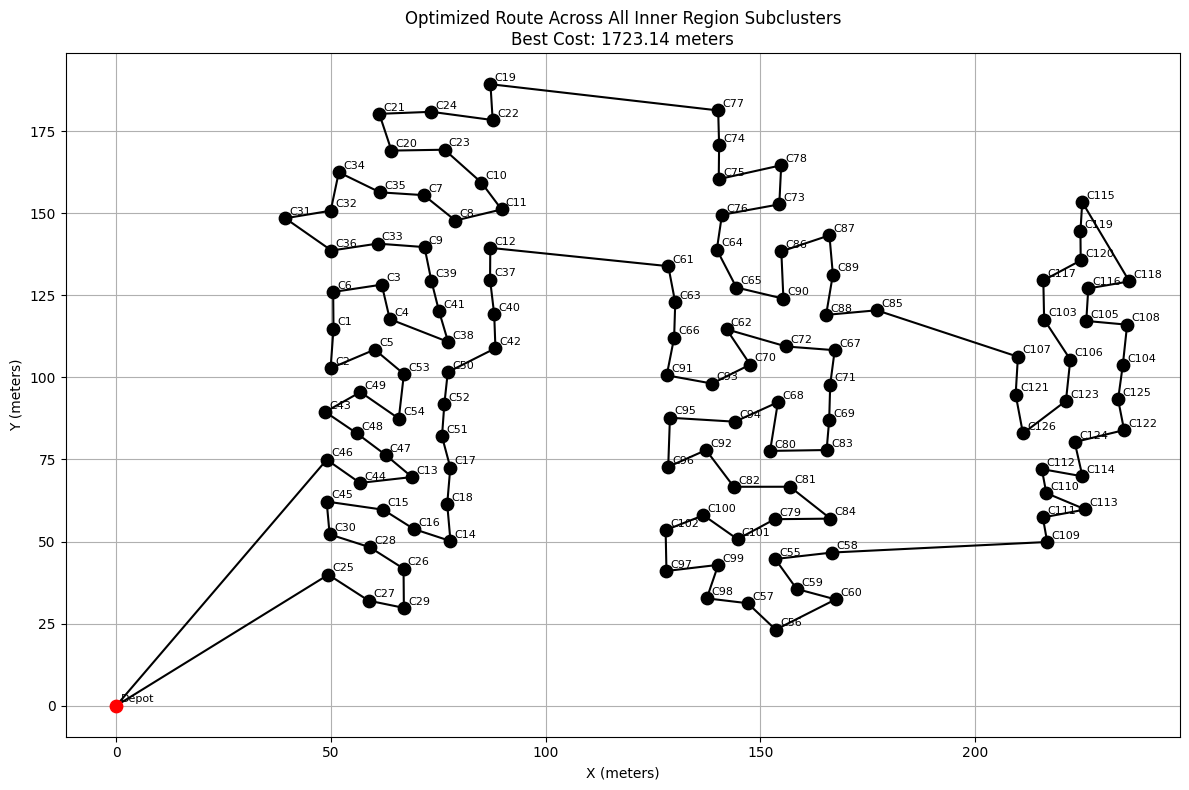

In [15]:
plt.figure(figsize=(12, 8))

# Gambar garis antar titik sesuai urutan rute
for i in range(len(hybrid_route) - 1):
    start = coords_with_depot[hybrid_route[i]]
    end = coords_with_depot[hybrid_route[i + 1]]
    plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', linewidth=1.5)

# Hubungkan titik terakhir ke titik awal (depot)
start = coords_with_depot[hybrid_route[-1]]
end = coords_with_depot[hybrid_route[0]]
plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', linewidth=1.5)

# Plot titik-titik dan beri label
for i, idx in enumerate(hybrid_route):
    point = coords_with_depot[idx]
    label = "Depot" if idx == 0 else f"C{idx}"
    plt.scatter(point[0], point[1], c='red' if idx == 0 else 'black', s=80, zorder=5)
    plt.annotate(label, (point[0] + 1, point[1] + 1), fontsize=8)

# Judul dan axis
plt.title(f"Optimized Route Across All Inner Region Subclusters\nBest Cost: {hybrid_cost:.2f} meters")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.grid(True)
plt.tight_layout()
plt.show()

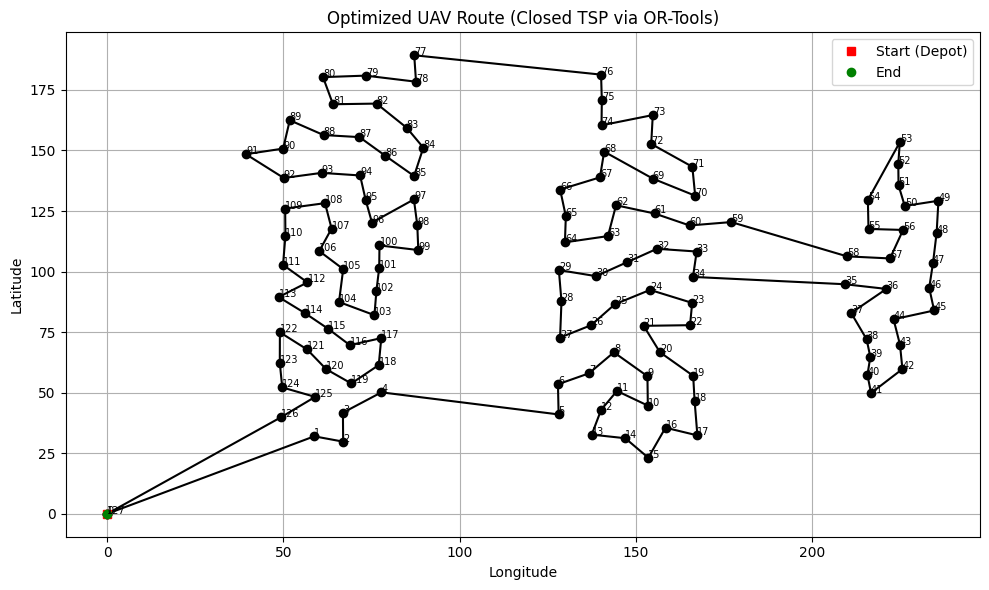

1692.7235253082924

In [12]:
def euclidean_distance_matrix(coords):
    size = len(coords)
    matrix = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            if i != j:
                matrix[i][j] = np.linalg.norm(coords[i] - coords[j])
    return matrix

def plot_route(coords, route):
    coords = np.array(coords)
    path = coords[route]

    plt.figure(figsize=(10, 6))
    plt.plot(path[:, 0], path[:, 1], 'o-', color='black')
    plt.plot(path[0, 0], path[0, 1], 'rs', label='Start (Depot)')
    plt.plot(path[-1, 0], path[-1, 1], 'go', label='End')

    for i, (x, y) in enumerate(path):
        plt.text(x, y, str(i), fontsize=7)

    plt.title("Optimized UAV Route (Closed TSP via OR-Tools)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def solve_tsp_closed(coords):
    distance_matrix = euclidean_distance_matrix(coords).tolist()
    num_nodes = len(coords)
    depot = 0  # titik awal dan akhir

    # Routing manager untuk Closed TSP
    manager = pywrapcp.RoutingIndexManager(num_nodes, 1, depot)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return int(distance_matrix[from_node][to_node] * 1000)  # konversi ke integer

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_params.time_limit.seconds = 10

    solution = routing.SolveWithParameters(search_params)

    if solution:
        index = routing.Start(0)
        route = []
        total_distance = 0
        while not routing.IsEnd(index):
            node = manager.IndexToNode(index)
            route.append(node)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            next_node = manager.IndexToNode(index)
            total_distance += distance_matrix[node][next_node]
        route.append(route[0])  # kembali ke depot
        return route, total_distance
    else:
        return None, None
    
# Jalankan optimasi
route, total_distance = solve_tsp_closed(coords_with_depot)

# Visualisasikan rute
if route:
    plot_route(coords_with_depot, route)

total_distance


=== Run 1 ===
Iterasi    0 | Cost: 1945.11 | Best: 1945.11 | Suhu: 100.00
Iterasi   50 | Cost: 1881.94 | Best: 1842.41 | Suhu: 77.83
Iterasi  100 | Cost: 1867.71 | Best: 1842.41 | Suhu: 60.58
Iterasi  150 | Cost: 1866.48 | Best: 1842.41 | Suhu: 47.15
Iterasi  200 | Cost: 1820.23 | Best: 1813.77 | Suhu: 36.70
Iterasi  250 | Cost: 1796.47 | Best: 1796.47 | Suhu: 28.56
Iterasi  300 | Cost: 1795.93 | Best: 1793.06 | Suhu: 22.23
Iterasi  350 | Cost: 1809.28 | Best: 1793.06 | Suhu: 17.30
Iterasi  400 | Cost: 1819.49 | Best: 1793.06 | Suhu: 13.47
Iterasi  450 | Cost: 1816.07 | Best: 1793.06 | Suhu: 10.48
Iterasi  500 | Cost: 1805.14 | Best: 1793.06 | Suhu: 8.16
Iterasi  550 | Cost: 1793.54 | Best: 1793.06 | Suhu: 6.35
Iterasi  600 | Cost: 1806.01 | Best: 1793.06 | Suhu: 4.94
Iterasi  650 | Cost: 1786.04 | Best: 1786.04 | Suhu: 3.85
Iterasi  700 | Cost: 1786.25 | Best: 1781.97 | Suhu: 2.99
Iterasi  750 | Cost: 1785.83 | Best: 1781.97 | Suhu: 2.33
Iterasi  800 | Cost: 1780.28 | Best: 1780.28 |

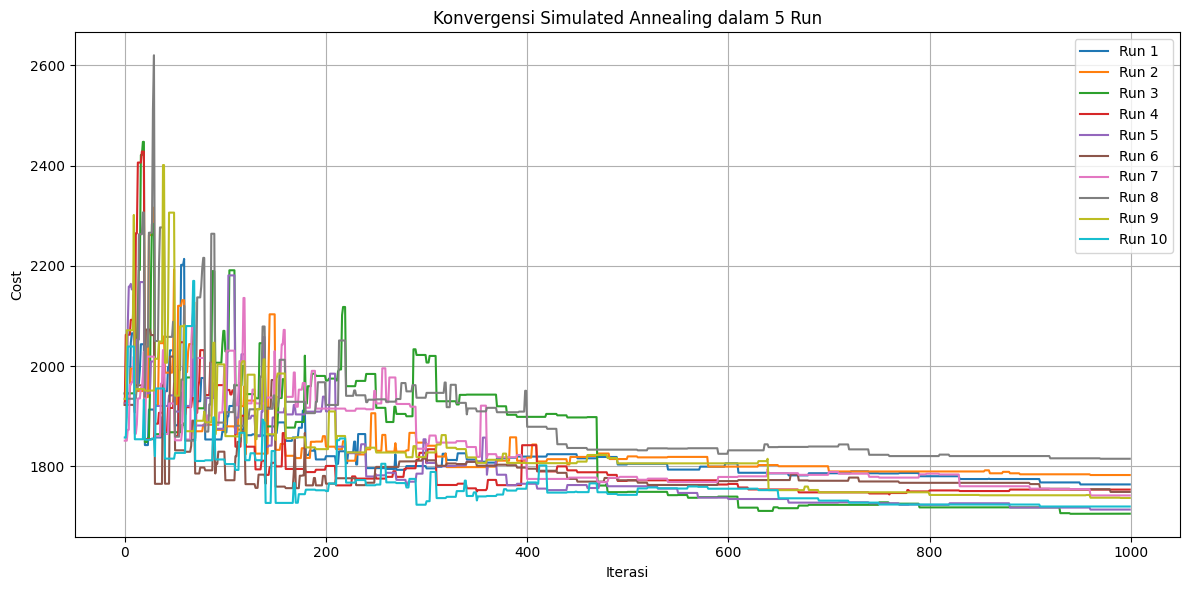


=== Summary Statistik Konvergensi ===
Run 1: Final Cost = 1763.94 | Iterasi = 1000
Run 2: Final Cost = 1782.70 | Iterasi = 1000
Run 3: Final Cost = 1705.35 | Iterasi = 1000
Run 4: Final Cost = 1743.87 | Iterasi = 1000
Run 5: Final Cost = 1713.77 | Iterasi = 1000
Run 6: Final Cost = 1748.99 | Iterasi = 1000
Run 7: Final Cost = 1741.97 | Iterasi = 1000
Run 8: Final Cost = 1815.15 | Iterasi = 1000
Run 9: Final Cost = 1736.89 | Iterasi = 1000
Run 10: Final Cost = 1719.88 | Iterasi = 1000

Rata-rata Final Cost: 1747.25
Best Overall Cost: 1705.35 (Run 3)


In [25]:
num_runs = 10
all_best_costs = []
all_best_routes = []
all_cost_logs = []

for run in range(num_runs):
    print(f"\n=== Run {run + 1} ===")
    initial_route = generate_greedy_initial_route(distance_matrix)
    best_route, best_cost, cost_log = simulated_annealing_with_periodic_2opt(distance_matrix, initial_route)
    all_best_costs.append(best_cost)
    all_best_routes.append(best_route)
    all_cost_logs.append(cost_log)

max_len = max(len(log) for log in all_cost_logs)
cost_df = pd.DataFrame({f"Run {i+1}": log + [None] * (max_len - len(log)) for i, log in enumerate(all_cost_logs)})

# Plot konvergensi
plt.figure(figsize=(12, 6))
for col in cost_df.columns:
    plt.plot(cost_df[col], label=col)
plt.xlabel("Iterasi")
plt.ylabel("Cost")
plt.title("Konvergensi Simulated Annealing dalam 5 Run")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary statistik
print("\n=== Summary Statistik Konvergensi ===")
for i, (cost, log) in enumerate(zip(all_best_costs, all_cost_logs)):
    print(f"Run {i+1}: Final Cost = {cost:.2f} | Iterasi = {len(log)}")

print(f"\nRata-rata Final Cost: {np.mean(all_best_costs):.2f}")
print(f"Best Overall Cost: {np.min(all_best_costs):.2f} (Run {np.argmin(all_best_costs)+1})")

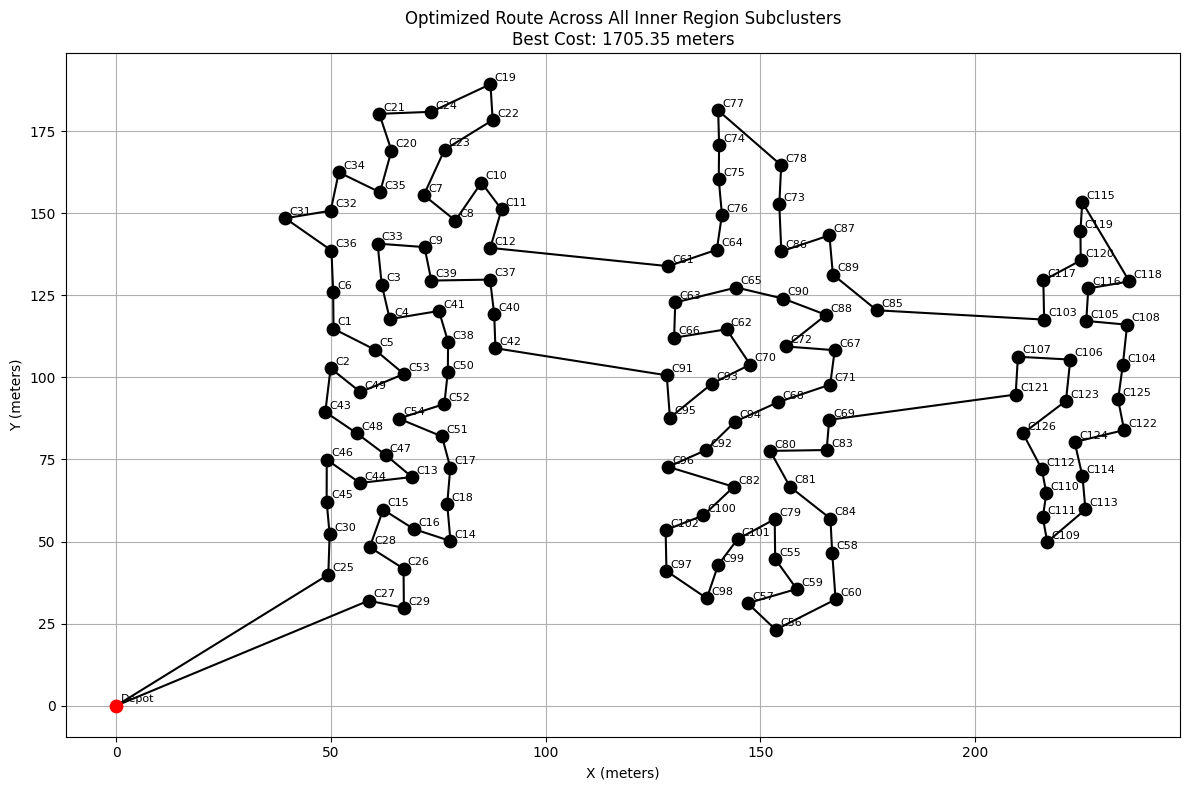

In [26]:
best_index = np.argmin(all_best_costs)
best_route = all_best_routes[best_index]
best_cost = all_best_costs[best_index]

# Visualisasi dengan style sesuai permintaan user
plt.figure(figsize=(12, 8))

# Gambar garis antar titik sesuai urutan rute
for i in range(len(best_route) - 1):
    start = coords_with_depot[best_route[i]]
    end = coords_with_depot[best_route[i + 1]]
    plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', linewidth=1.5)

# Hubungkan titik terakhir ke titik awal (depot)
start = coords_with_depot[best_route[-1]]
end = coords_with_depot[best_route[0]]
plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', linewidth=1.5)

# Plot titik-titik dan beri label
for i, idx in enumerate(best_route):
    point = coords_with_depot[idx]
    label = "Depot" if idx == 0 else f"C{idx}"
    plt.scatter(point[0], point[1], c='red' if idx == 0 else 'black', s=80, zorder=5)
    plt.annotate(label, (point[0] + 1, point[1] + 1), fontsize=8)

# Judul dan axis
plt.title(f"Optimized Route Across All Inner Region Subclusters\nBest Cost: {best_cost:.2f} meters")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
def euclidean_distance_matrix(coords):
    size = len(coords)
    matrix = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            if i != j:
                matrix[i][j] = np.linalg.norm(coords[i] - coords[j])
    return matrix

def plot_route(coords, route):
    coords = np.array(coords)
    path = coords[route]

    plt.figure(figsize=(10, 6))
    plt.plot(path[:, 0], path[:, 1], 'o-', color='black')
    plt.plot(path[0, 0], path[0, 1], 'rs', label='Start (Depot)')
    plt.plot(path[-1, 0], path[-1, 1], 'go', label='End')

    for i, (x, y) in enumerate(path):
        plt.text(x, y, str(i), fontsize=7)

    plt.title("Optimized UAV Route (Closed TSP via OR-Tools)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def solve_tsp_closed(coords):
    distance_matrix = euclidean_distance_matrix(coords).tolist()
    num_nodes = len(coords)
    depot = 0  # titik awal dan akhir

    # Routing manager untuk Closed TSP
    manager = pywrapcp.RoutingIndexManager(num_nodes, 1, depot)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return int(distance_matrix[from_node][to_node] * 1000)  # konversi ke integer

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_params.time_limit.seconds = 5

    solution = routing.SolveWithParameters(search_params)

    if solution:
        index = routing.Start(0)
        route = []
        total_distance = 0
        while not routing.IsEnd(index):
            node = manager.IndexToNode(index)
            route.append(node)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            next_node = manager.IndexToNode(index)
            total_distance += distance_matrix[node][next_node]
        route.append(route[0])  # kembali ke depot
        return route, total_distance
    else:
        return None, None

In [7]:
import time

In [16]:
num_runs = 10
all_best_costs = []
all_best_routes = []
all_durations = []

for run in range(num_runs):
    start_time = time.time()
    route, total_distance = solve_tsp_closed(coords_with_depot)
    duration = time.time() - start_time

    all_best_costs.append(total_distance)
    all_best_routes.append(route)
    all_durations.append(duration)

# --- DataFrame hasil ---
results_df = pd.DataFrame({
    "Run": [f"Run {i+1}" for i in range(num_runs)],
    "Best Cost": [f"{c:.2f}" if c else "None" for c in all_best_costs],
    "Durasi (detik)": [f"{t:.2f}" for t in all_durations]
})
from IPython.display import display
display(results_df)


,Run,Best Cost,Durasi (detik)
0,Run 1,1692.72,5.17
1,Run 2,1692.72,5.06
2,Run 3,1692.72,5.06
3,Run 4,1692.72,5.06
4,Run 5,1692.72,5.07
5,Run 6,1692.72,5.06
6,Run 7,1692.72,5.06
7,Run 8,1692.72,5.06
8,Run 9,1692.72,5.05
9,Run 10,1692.72,5.05


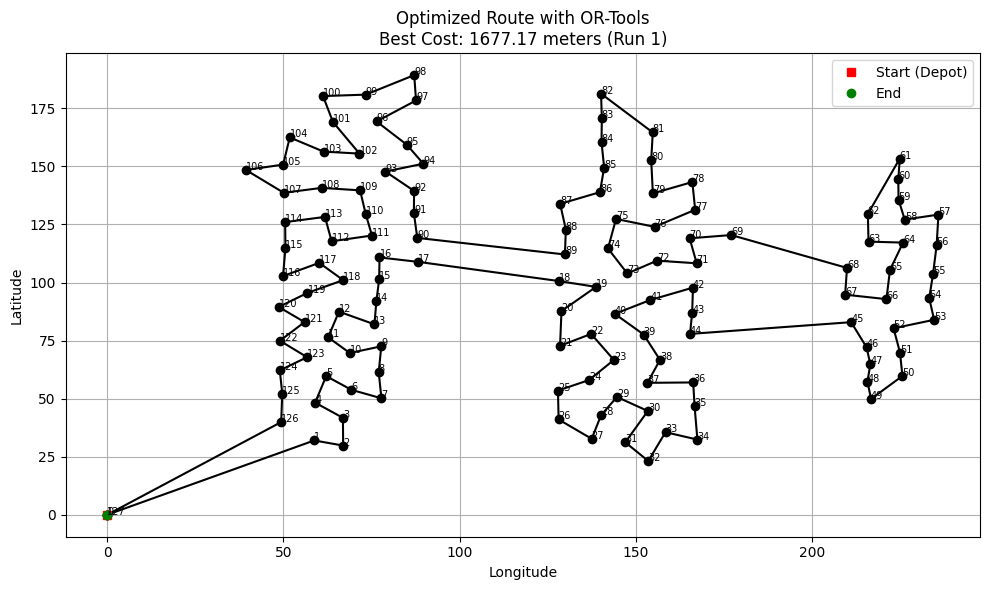

In [12]:
# --- Cari run terbaik dan plot rute terbaiknya ---
best_index = np.argmin(all_best_costs)
best_route = all_best_routes[best_index]
best_cost = all_best_costs[best_index]

def plot_route(coords, route, title=""):
    coords = np.array(coords)
    path = coords[route]

    plt.figure(figsize=(10, 6))
    plt.plot(path[:, 0], path[:, 1], 'o-', color='black')
    plt.plot(path[0, 0], path[0, 1], 'rs', label='Start (Depot)')
    plt.plot(path[-1, 0], path[-1, 1], 'go', label='End')

    for i, (x, y) in enumerate(path):
        plt.text(x, y, str(i), fontsize=7)

    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_route(coords_with_depot, best_route, 
           title=f"Optimized Route with OR-Tools\nBest Cost: {best_cost:.2f} meters (Run {best_index+1})")

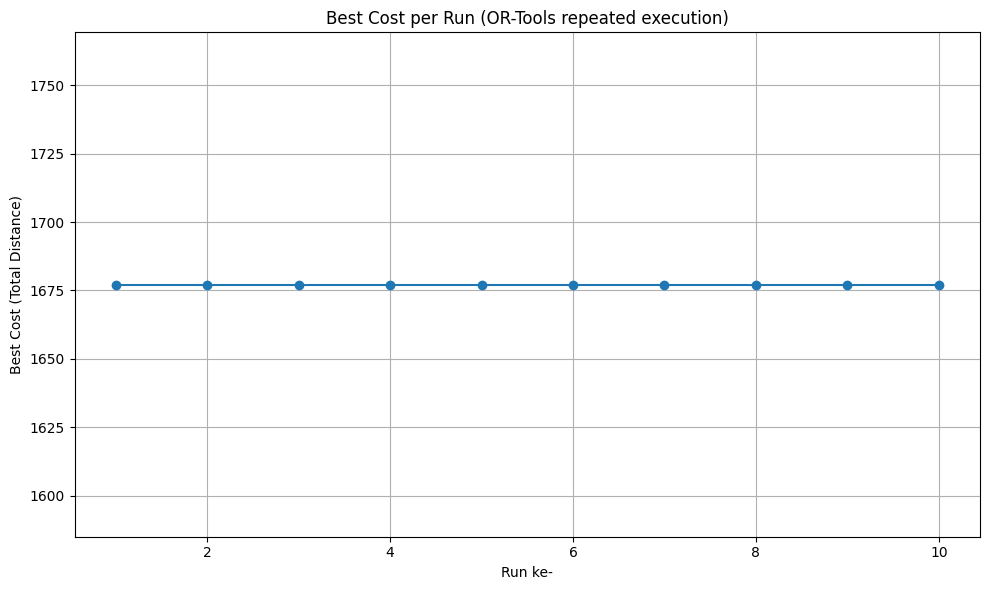

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_runs+1), all_best_costs, marker='o', linestyle='-')
plt.xlabel("Run ke-")
plt.ylabel("Best Cost (Total Distance)")
plt.title("Best Cost per Run (OR-Tools repeated execution)")
plt.grid(True)
plt.tight_layout()
plt.show()